In [190]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [191]:
import numpy as np
import pandas as pd

In [192]:
import datetime as dt

In [193]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [202]:
# Create Engine using SQL Lite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [203]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [204]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [205]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [206]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [207]:
# Use `engine.execute` to select and display the first 5 rows from the measurement table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [208]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [209]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [217]:
#query the database for a years worth of precipitation data. Focus on most recent.
precipitation_analysis_1 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2017-08-23").\
    filter(Measurement.date <= "2018-08-23").all()

In [218]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [219]:
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [220]:
prcp = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

prcp_df = pd.DataFrame(prcp, columns=['date','prcp'])
prcp_df.set_index('date').head()
prcp_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


<Figure size 360x288 with 0 Axes>

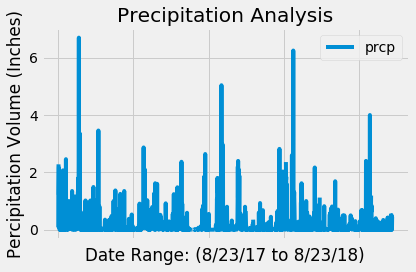

In [221]:
#Use Pandas with Matplotlib to Plot the Data
fig1 = plt.figure(figsize=(5,4))
prcp_df.plot('date', 'prcp')
plt.grid(True)
plt.xlabel("Date Range: (8/23/17 to 8/23/18)")
plt.ylabel("Percipitation Volume (Inches)")
plt.title("Precipitation Analysis")
plt.legend()
plt.tight_layout()
plt.show()
plt.close(fig1)

In [222]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [223]:
# Design a query to show how many stations are available in this dataset
location_station=session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations that are available.".format(location_station))

There are 9 stations that are available.


In [224]:
# What are the most active stations? (i.e.  what stations have the most rows)?
weather_observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

popular_station = weather_observations[0][0]    
popular_station

'USC00519281'

In [225]:
# List the stations and the counts in descending order.
print("-----------------------------------------------------------------")
print("The most active station is",popular_station,"and contains",weather_observations[0][1],"weather observations.")
print("-----------------------------------------------------------------")
print("This is a list of the most active stations, displayed in descending order:")
for station, count in weather_observations:
    print("this station id:",station,"has this many weather observations:",count,)

-----------------------------------------------------------------
The most active station is USC00519281 and contains 2772 weather observations.
-----------------------------------------------------------------
This is a list of the most active stations, displayed in descending order:
this station id: USC00519281 has this many weather observations: 2772
this station id: USC00519397 has this many weather observations: 2724
this station id: USC00513117 has this many weather observations: 2709
this station id: USC00519523 has this many weather observations: 2669
this station id: USC00516128 has this many weather observations: 2612
this station id: USC00514830 has this many weather observations: 2202
this station id: USC00511918 has this many weather observations: 1979
this station id: USC00517948 has this many weather observations: 1372
this station id: USC00518838 has this many weather observations: 511


In [226]:
# Using the station id from the previous query, calculatethe lowest temperature recorded,
# highest temperature recorded, and average temperature most active station.
temperature_intel = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == popular_station).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

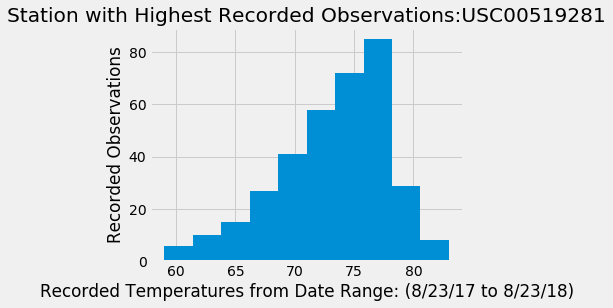

In [227]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results with a histogram
fig2 = plt.figure(figsize=(5,4))
plt.grid(True)
temp_intel_df = pd.DataFrame(temperature_intel)
plt.hist(temp_intel_df['tobs'])
bin_size = 12
plt.xlabel("Recorded Temperatures from Date Range: (8/23/17 to 8/23/18)")
plt.ylabel("Recorded Observations")
plt.title("Station with Highest Recorded Observations:" + popular_station)
plt.show()

In [228]:
def calc_temps(trip_start_date, trip_end_date, most_recent_date):
    
    m_yr = most_recent_date[0:4]
    m_md = str(most_recent_date[5:7]) + str(most_recent_date[8:10])
    if m_md[0:1] == "0":
        m_md = m_md[1:] 
        
    t_yr = trip_end_date[0:4]
    t_md = str(trip_end_date[5:7]) + str(trip_end_date[8:10])
    if t_md[0:1] == "0":
        t_md = t_md[1:]
   
    if (eval(t_yr) > eval(m_yr) and eval(m_md) >= eval(t_md)):
        yr_adjust = 0
    elif eval(t_yr) < eval(m_yr) and eval(t_md) <= eval(m_md):
        yr_adjust = 0
    else:
        yr_adjust = 1   
    
    search_start_date = str(eval(most_recent_date[0:4])-yr_adjust) + trip_start_date[4:]
    search_end_date = str(eval(most_recent_date[0:4])-yr_adjust) + trip_end_date[4:]
    
    trip_stats = session.query(func.min(Measurement.tobs),
                               func.avg(Measurement.tobs),
                               func.max(Measurement.tobs))\
    .filter(Measurement.date >= search_start_date)\
    .filter(Measurement.date <= search_end_date).all()
    TMIN = trip_stats[0][0]
    TAVG = trip_stats[0][1]
    TMAX = trip_stats[0][2]
    
    return TMIN, TAVG, TMAX, search_start_date, search_end_date

In [229]:
# Calculated date 
most_recent_date = session.query(Measurement.date)\
    .order_by(Measurement.date.desc()).first() 
most_recent_date = most_recent_date[0]

In [230]:
start_date = "2017-8-23"
end_date = "2018-8-23"

# Process dates for appropriate year's data query
TMIN, TAVG, TMAX, search_sd, search_ed = calc_temps(start_date, end_date, most_recent_date)
tmp_avg = "{0:.1f}".format(TAVG)

# Print RESULTS:
print()
print(f"Most recent termperature data available is up until:\n  {most_recent_date}")
print()
print(f"Trip Start and End dates:\n  {start_date}\n  {end_date}")
print(f"Calculated Search Dates based on Trip Ending Date:\n  {search_sd}\n  {search_ed}")
print(f"RESULTS:\n  Temp Min: {TMIN}  Temp Avg: {tmp_avg}  Temp: {TMAX}")

TypeError: unsupported format string passed to NoneType.__format__

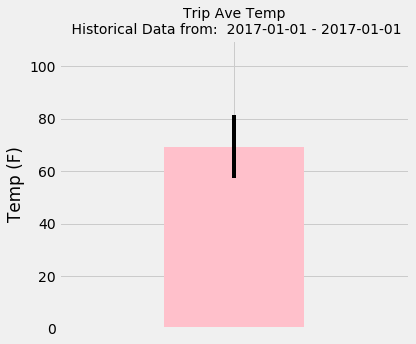

<Figure size 432x288 with 0 Axes>

In [71]:
# Plot figure for Trip Ave Temp
plt.subplots(figsize=(6,5))
plt.xlim(0, 2)
plt.ylim([0,110])
plt.bar(1, TAVG, color = 'pink', yerr = TMAX-TMIN, tick_label="", align='center')
plt.title(f"Trip Ave Temp\n Historical Data from:  {search_sd} - {search_ed}", fontsize=14)
plt.ylabel("Temp (F)")
plt.tight_layout()

plt.show()
plt.savefig('trip_ave_temp.png')